### Imports
***

In [1]:
import time
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import identity, csr_matrix
from scipy.sparse.linalg import spsolve_triangular
import matplotlib.pyplot as plt

### Helper Functions
***

In [2]:
def matrix_from_file(filename, n=281903):
    """
        Function to read matrix into sparse format.
        The matrix is purposedely stored into Transpose Form
        so the further computations are faster in implementation
        For Power Method, the Matrix P is not to be altered in any way
        so this function does not corrupt the results, its just for convenience.
    """
    
    outbound_nodes = []
    inbound_nodes = []    
    weights = []

    with open(filename,'r') as f:
        for i in f.readlines():
            outbound_node, inbound_node, weight = (x for x in i.split())
            inbound_nodes.append(int(inbound_node)-1)
            outbound_nodes.append(int(outbound_node)-1)
            weights.append(float(weight))

    n = len(set(inbound_nodes) | set(outbound_nodes))
    a = np.zeros(n)
    P = csr_matrix((weights,(inbound_nodes,outbound_nodes)), shape=(n,n))
    a[list(set(inbound_nodes).difference(set(outbound_nodes)))] = 1
    return P, a

### Read the data and structure them under a sparse matrix

In [3]:
P, a = matrix_from_file('./stanweb.dat')

### Power Method
***

In [4]:
def power_method(P, a, alpha, power_tol=1e-8, per_node_tol=1e-8):
    """
    Implementation of the Power Method Algorithm with Hyperparameter Alpha.
    Results in:
        1) The PageRank vector p.
        2) The per-node number of convergence iterations.
        3) Total iterations
        4) Elapsed Time
    """
    n = P.shape[0]
    ### Initialize the PageRank Vector p, the personalization vector v, an the P(per) N(ode) C(onvergence) V(ector)
    ### and keep the value (1-alpha) * v into a variable since it is going to be reused at run time.
    v = p_old = p_new = np.ones(n)/n
    pncv = np.zeros(n)
    const = (1-alpha)*v 

    def perform_iteration(P, p_old, alpha, v, const):
        p_new = alpha * P.dot(p_old) + alpha * np.dot(np.dot(a, p_old), v) + const
        ### Normalize in order for new PageRank Vector to repsresent a probability vector
        p_new /= np.linalg.norm(p_new, ord = 1)
        return p_new


    def update_convergence_vector(iteration_counter, p_new, p_old, pncv, per_node_tol):
        relative_residual = np.abs(np.subtract(p_new, p_old) / p_old)
        condition_to_update = (relative_residual <= per_node_tol)  &  (pncv==0)
        pncv[condition_to_update] = iteration_counter
        return pncv

    iteration_counter = 1
    start = time.time()
    while (np.linalg.norm(p_new-p_old, ord=1) >= power_tol) | (iteration_counter == 1):
        p_old = p_new.copy()
        p_new = perform_iteration(P, p_old, alpha, v, const)
        pncv = update_convergence_vector(iteration_counter, p_new, p_old, pncv, per_node_tol)          
        iteration_counter +=1
    stop = time.time() 
    elapsed = stop - start
    
    return p_new, iteration_counter, pncv, elapsed

### Gauss-Seidel
***

In [5]:
def GaussSeidel(P, a, alpha, gs_tol=1e-8, per_node_tol=1e-8):
    """
    Implementation of the Gauss Seidel Method with Hyperparameter Alpha.
        Results in:
        1) The PageRank vector p.
        2) The per-node number of convergence iterations.
        3) Total iterations
        4) Elapsed Time

    """
    n = P.shape[0]
    ### Initialize the PageRank Vector p, the personalization vector v, an the P(per) N(ode) C(onvergence) V(ector)
    ### and keep the value (1-alpha) * v into a variable since it is going to be reused at run time.
    v = p_old = p_new = np.ones(n)/n 
    pncv = np.zeros(n)
    const = (1-alpha)*v 


    
    M = identity(n) - sparse.tril(alpha*P, k = 0)
    R = sparse.triu(alpha*P, k = 1)
    
    def perform_iteration(M, R, p_old, alpha, v, const):
        p_new = spsolve_triangular(M,(R.dot(p_old) + alpha * v * np.dot(a,p_old) + const)) 
        ### Normalize in order for new PageRank Vector to repsresent a probability vector
        p_new /= np.linalg.norm(p_new, ord = 1)
        return p_new

    def update_convergence_vector(iteration_counter, p_new, p_old, pncv, per_node_tol):
        relative_residual = np.abs(np.subtract(p_new, p_old) / p_old)
        condition_to_update = (relative_residual <= per_node_tol)  &  (pncv==0)
        pncv[condition_to_update] = iteration_counter
        return pncv

    iteration_counter = 1
    start = time.time()
    while (np.linalg.norm(p_new-p_old, ord=1) >= gs_tol) | (iteration_counter == 1):
        p_old = p_new.copy()
        p_new = perform_iteration(M, R, p_old, alpha, v, const)
        pncv = update_convergence_vector(iteration_counter, p_new, p_old, pncv, per_node_tol)   
        iteration_counter +=1
    stop = time.time() 
    elapsed = stop - start
    
    return p_new, iteration_counter, pncv, elapsed

## Question A: Find vector $\pi$ using $\alpha=0.85$ and τ = $10^{-8}$
***

In [6]:
pi_vector_pm_85, iterations_pm_85, pncv_pm_85, elapsed_pm_85 = power_method(P, a, alpha=0.85)
print("############ POWER METHOD #############")
print('Pagerank using the Power Method for alpha=0.85:')
print('Iterations:', iterations_pm_85)
print('Elapsed time (s):', round(elapsed_pm_85, 3))
print()

pi_vector_gs_85, iterations_gs_85, pncv_gs_85, elapsed_gs_85 = GaussSeidel(P, a, alpha=0.85)
print("######### Gauss Seidel METHOD ##########")
print('PageRank using the Gauss-Seidel method for a=0.85:')
print('Iterations:', iterations_gs_85)
print('Elapsed time (s):', round(elapsed_gs_85,3))

############ POWER METHOD #############
Pagerank using the Power Method for alpha=0.85:
Iterations: 92
Elapsed time (s): 1.849

######### Gauss Seidel METHOD ##########
PageRank using the Gauss-Seidel method for a=0.85:
Iterations: 49
Elapsed time (s): 59.084


### Results Explanatory Analysis
***

In [7]:
def get_top_k_nodes(pi_vector, k):
    """
        Returns the position and values of the top K nodes with largest PageRank
    """
    position = pi_vector.argsort()[-k::][::-1] + 1
    values = pi_vector[position - 1]
    return position, values

In [8]:
def analysis_at_top_nodes(pi_vector_pm, pi_vector_gs, top_node_list, alpha):
    """
        Performs Side by Side analysis for the 2 methods
        regarding the top nodes.
    """
    for k in top_node_list:
        position_pm , values_pm = get_top_k_nodes(pi_vector_pm, k)
        position_gs , values_gs = get_top_k_nodes(pi_vector_gs, k)
        analysis = {
          'Rank': range(1, k+1),
          'Node_ID_Power_Method': position_pm,
          'Node_PageRank_Power_Method': values_pm,
          'Node_ID_GS': position_gs,
          'Node_PageRank_GS': values_gs
          }
        frame = pd.DataFrame(analysis)
        frame.to_csv(f"Top_{k}_analysis_at_alpha_{alpha}.csv", index=False)
        if np.array_equal(position_pm, position_gs):
            print(f"Results are the same for Top {k} values!\n")
        else:
            print(f"Results are different for Top {k} values!\n")
    


In [9]:
analysis_at_top_nodes(pi_vector_pm=pi_vector_pm_85, pi_vector_gs=pi_vector_gs_85, top_node_list=[10,25,50], alpha=0.85)

Results are the same for Top 10 values!

Results are the same for Top 25 values!

Results are different for Top 50 values!



### Summary on Question A
***

* As far as the results are concerned, for the top 10 and top 25 nodes both the node ordering as well as their values are preserved across the methods.
Some mild differences begin to appear in the top 50 nodes. 

* Solving PageRank required:
    * Power Method $\simeq$ 92 iterations
    * Gauss-Siedel method  $\simeq$ 49 iterations


* Solving PageRank using the Power method took $\simeq$ 2s, much faster than with the Gauss-Siedel method at $\simeq$ 60 s

## Question B: Find vector $\pi$ using $\alpha=0.99$ and τ = $10^{-8}$
***

In [10]:
pi_vector_pm_99, iterations_pm_99, pncv_pm_99, elapsed_pm_99 = power_method(P, a, alpha=0.99)
print("############ POWER METHOD #############")
print('Pagerank using the Power Method for alpha=0.85:')
print('Iterations:', iterations_pm_99)
print('Elapsed time (s):', round(elapsed_pm_99, 3))
print()

pi_vector_gs_99, iterations_gs_99, pncv_gs_99, elapsed_gs_99 = GaussSeidel(P, a, alpha=0.99)
print("######### Gauss Seidel METHOD ##########")
print('PageRank using the Gauss-Seidel method for a=0.85:')
print('Iterations:', iterations_gs_99)
print('Elapsed time (s):', round(elapsed_gs_99,3))

############ POWER METHOD #############
Pagerank using the Power Method for alpha=0.85:
Iterations: 1393
Elapsed time (s): 28.138

######### Gauss Seidel METHOD ##########
PageRank using the Gauss-Seidel method for a=0.85:
Iterations: 610
Elapsed time (s): 1047.957


### Results Explanatory Analysis
***

In [11]:
analysis_at_top_nodes(pi_vector_pm=pi_vector_pm_99, pi_vector_gs=pi_vector_gs_99, top_node_list=[10,25,50], alpha=0.99)

Results are the same for Top 10 values!

Results are different for Top 25 values!

Results are different for Top 50 values!



### Summary on Question B
***

* As far as the results are concerned, only the top 10 nodes maintain ordering in terms of pagerank values.
Some mild differences begin to appear in the top 25 nodes, and larger at 50 nodes. 

* Solving PageRank required:
    * Power Method $\simeq$ 1393 iterations
    * Gauss-Siedel method  $\simeq$ 610 iterations


* Solving PageRank using the Power method took $\simeq$ 30s, much faster than with the Gauss-Siedel method at $\simeq$ 1040 s

### Explanatory Analysis Between Alphas
***

### TOP 10 Power methods for alpha 0.85 and for alpha 0.99


In [12]:
### For Top 10
power_method_85 = pi_vector_pm_85[0:10]
power_method_99 = pi_vector_pm_99[0:10]


if np.array_equal(power_method_85, power_method_99):
    print(f"Results are the same for Top 10 values for Power Methods!\n")
else:
    print(f"Results are different for Top 10 values for Power Methods!\n")

Results are different for Top 10 values for Power Methods!



### TOP 10 Gauss Seidel methods for alpha 0.85 and for alpha 0.99


In [13]:
### For Top 10
gs_method_85 = pi_vector_gs_85[0:10]
gs_method_99 = pi_vector_gs_99[0:10]


if np.array_equal(gs_method_85, gs_method_99):
    print(f"Results are the same for Top 10 values for GS Methods!\n")
else:
    print(f"Results are different for Top 10 values for GS Methods!\n")

Results are different for Top 10 values for GS Methods!



Thus the ranking of the top 50 nodes changes for both methods when changing the parameter $\alpha$ from 0.85 to 0.99.

### Node Convergence Analysis
***

### Iterations to Convergence vs Ranking for Power method at $\alpha=0.85$
***

In [23]:
def plot_convergence(pncv_vector,pi_vector, name):
    ### Iterations Per Node
    y_calc = pncv_vector[np.argsort(pi_vector)[::-1]]

    ###  Mean of Iterations per 100 Nodes
    ### Skip last 3 nodes so it is divisible by 100
    y_calc_mean = np.mean(y_calc[:-3].reshape(-1, 100), axis=1)

#     Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r
    
    plt.figure(figsize=(14,7))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1,2,1)
    plt.title("Full Convergence Analysis")
    plt.scatter(range(0,281903), y_calc, s=0.3, alpha=0.7, cmap='viridis', c=y_calc)
    plt.xlabel('Rank')
    plt.ylabel('Iterations per node')
    plt.subplot(1,2,2)
    plt.title("Average per 100 Convergence Analysis")
    plt.scatter(range(0,y_calc_mean.shape[0]), y_calc_mean, s=10, alpha=0.9, cmap='jet', c=y_calc_mean)
    plt.xlabel('Rank')
    plt.ylabel('Iterations per node')
    plt.savefig(name+'.png')
    plt.show()
    plt.close()
    return

### Power method for $\alpha=0.85$

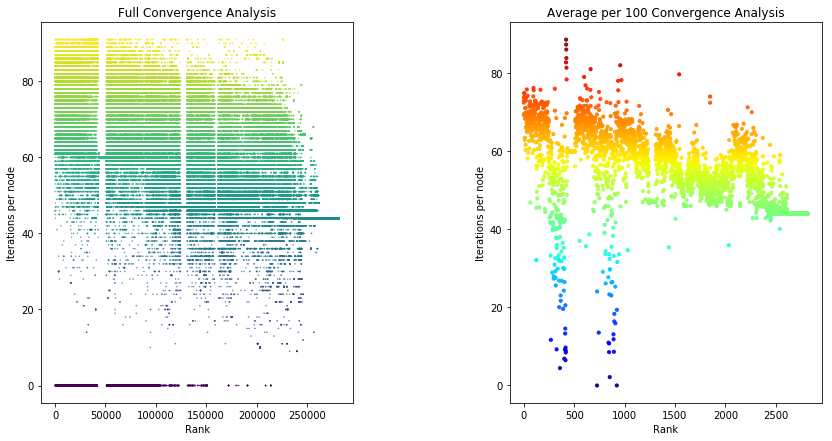

In [24]:
plot_convergence(pncv_pm_85,pi_vector_pm_85, name='pm_85')

### Power method for $\alpha=0.99$

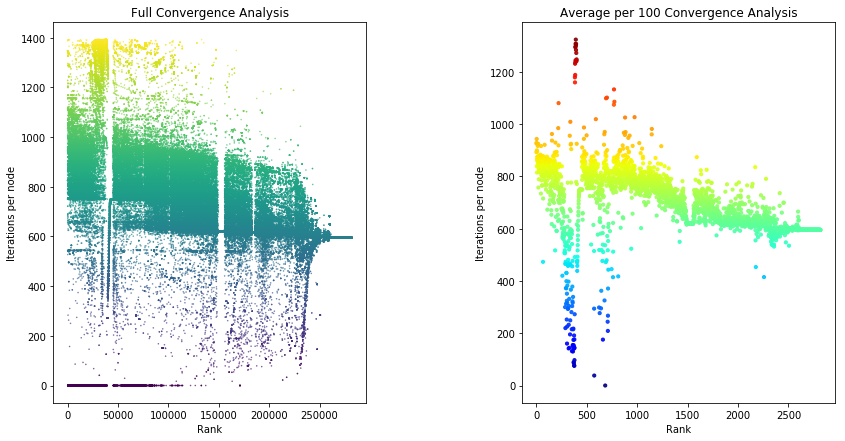

In [25]:
plot_convergence(pncv_pm_99,pi_vector_pm_99, name='pm_99')

### Gauss-Seidel method for $\alpha=0.85$

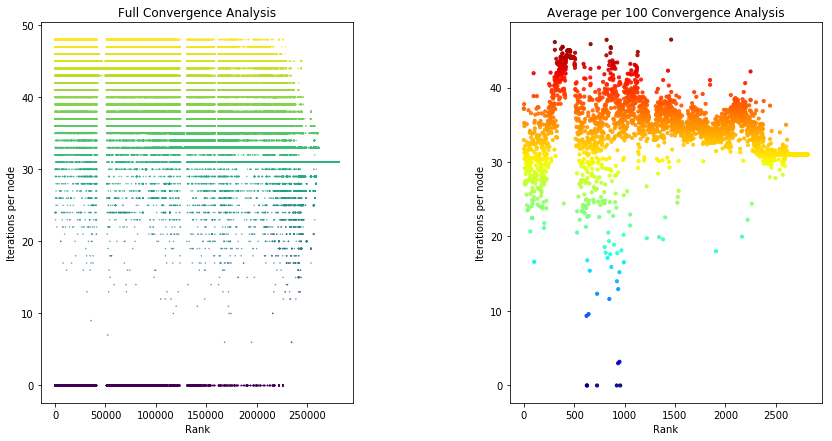

In [26]:
plot_convergence(pncv_gs_85,pi_vector_gs_85, name='gs_85')

### Gauss-Seidel method for $\alpha=0.99$

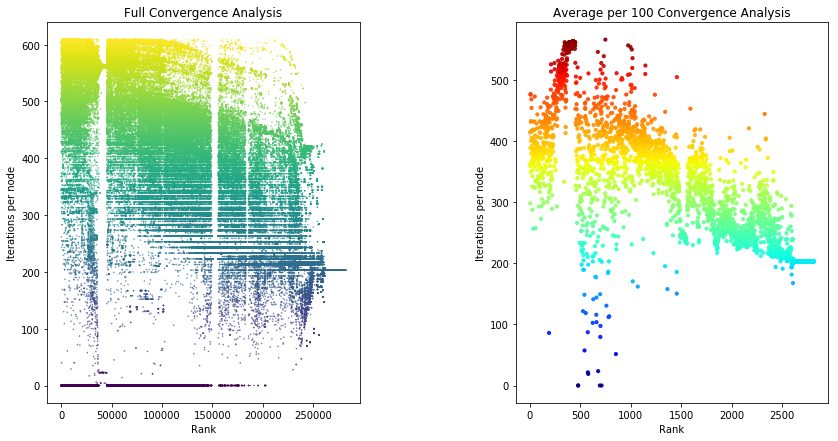

In [27]:
plot_convergence(pncv_gs_99,pi_vector_gs_99, name='gs_99')

### Summary on Convergence Plots
***

Both the above plots (full analysis and per 100 average) give us the following result:

* The Highest Ranking Nodes need on average more iterations to converge than the Lowest Ranking Nodes.
This is to no surprise due to the fact that the low rank nodes tend to have more outgoing than incoming connections, thus "flowing" pagerank faster towards other nodes while their pagerank is fastly converging to a value near the predefined threshold.
The opposite happens to the high rank nodes, where the vast incoming connections give boost to their pagerank constantly until a point where they fluctuate around the specific threshold.


### Written Exercises
***

### Question A): 
You now create a new web page X (thus adding a node to the web graph). X has neither in-links, nor out-links. Let $\hat{π}$  denote the vector of new PageRanks of the n old web pages, and x denote the new PageRank of page X: In other words, ($\hat{π}$,x) is the PageRank vector of the new web graph. Write $\hat{π}$ and x in terms of r: Comment on how the PageRanks of the older pages changed due to the addition of the new page (remember n is a very large number).

#### Answer:
***

Let $\pi$ be the PageRank vector and  $\pi_i$ PageRank of the i-th node in it.
Also let $a$ (usually 0.85) be the damping factor used to model the probability of a surfer to move from page to page by clicking on links.
Finally , $n$ is the size of the nodes in our graph, $n_j$ the number of outbound connections of node $j$ and $S_i$ the set of all the nodes that have outbound connections to node $i$ we can state that the stationary form of the i-th node's PageRank is:

 

$$\pi_i = \frac{1-a}{n} + a\sum_{j \in S_{i}}\frac{\pi_j}{n_j} \$$

***

Now let's insert a new node $X$ without inbound nor outbound (dangling) connections to the web graph. We have that each node will be now updated to:

$$\hat{\pi_i} = \frac{1-a}{n+1} + a\sum_{j \in S_{i}}\frac{\pi_j}{n_j} \ \ $$

or in terms of $\pi_i$:

$$\hat{\pi_i} = \frac{a-1}{n(n+1)} + \pi_i$$



_Note 1: We dont have to worry for $n_j =0$ for node $X$, since it does not belong in any set $S_i$_
***
_Note 2: The upper applies vice-versa: Since $X$ does not have any inbound nodes the respective set $S_i = \emptyset$_

Thus, the PageRank of node X is :

$$\pi{X} = \frac{1-a}{n+1} \ \$$


***
We can now make use of the fact that n is a very large number and for ${n\to\infty}$ we have:

$$\lim_{n\to\infty}\hat{\pi_i} = \lim_{n\to\infty}[\frac{a-1}{n(n+1)} + \pi_i] = \pi_i$$


We can so claim that the PageRanks of the older pages-nodes do not change.

### Question B): 
Unsatisﬁed with the PageRank of your page $X$, you create another page $Y$ (with no in-links) that links to $X$: What are the PageRanks of all the $n + 2$ pages now? Does the PageRank of $X$ improve?

#### Answer:
***

We now add a node $Y$ without inbound nodes _(so we can already calculate its PageRank just like above)_ but with outbound nodes linking to $X$.

The PageRank of a random node $i$ is updated to:

$$\tilde{\pi_i} = \frac{1-a}{n+2} + a\sum_{j \in S_{i}}\frac{\hat{\pi_j}}{n_j} \simeq \frac{1-a}{n+2} + a\sum_{j \in S_{i}}\frac{\pi_j}{n_j}\ \ \$$



The PageRank of node $X$ is now:

$$\tilde{\pi X} = \frac{1-a}{n+2} + a \tilde{\pi Y}$$

_Note 3: The upper applies since only node $Y$ belongs in X's inbound set_
***



The PageRank of node $Y$ is as expected:

$$\tilde{\pi Y} = \frac{1-a}{n+2}$$

And finally we can see that the PageRank of node $X$ increases in comparison with the previous step 
at value:

$$\tilde{\pi X} - \hat{\pi X} = (a+1)\frac{1-a}{n+2} - \frac{1-a}{n+1}  =  (1-a) \frac{a(n + 1) -1}{(n+2)(n+1)} > 0$$
***

For the rest nodes and for ${n\to\infty}$ we get yet again:

$$\lim_{n\to\infty}\tilde{\pi_i} = \lim_{n\to\infty}[\frac{1-a}{n+2} + a\sum_{j \in S_i}\frac{\pi_i}{n_j}] = \pi_i$$


We can so claim that the PageRanks of the older pages-nodes do not change once again.

### Question C): 
Still unsatisﬁed, you create a third page $Z$: How should you set up the links on your three pages so as to maximize the PageRank of $X$?
***


### In the previous questions we showed that:
* Adding a dummy no-inbound no-outbound node $X$, does not affect any other node other than giving an arbitrary pagerank to itself.

* The PageRank of node $X$ increases by adding a node $Y$ having outbound links to node $X$ and no inbound links.

* Thus in order to further increase the PageRank of node $X$ we utilize an additional node $Z$ having outbound links to node $X$.

The best trick would be to link node $Y$ with node $X$ and node $Z$ with node $X$ and create backward links from $X$ to $Y$ and $Z$ respectively. In this way we "retrofeed" some of the PageRank back to our dummy pages and boost the $X$ page even more.
***

### Question D): 
You have one last idea, you add links from your page $X$ to older, popular pages (e.g.: you add a list of Useful links on your page).

Does this improve the PageRank of $X$? Does the answer change if you add links from $Y$ or $Z$ to older, popular pages?
***


Given $n$ is a very large number, PageRank of node $X$ depends almost completely on its inbound flow of its links.
Adding links from node $X$ to older popular nodes will not change the PageRank of node $X$.
Adding links from nodes $Y$ and $Z$ to older popular nodes does not change their PageRank as well neither affects the boosting of our system.

### Question E): 
Describe what steps you might take to raise the PageRank of X further. You do not need to prove anything here, just summarize your thoughts based on the previous parts. For extra credit though, you can prove what the structure for a link farm with m nodes should be to optimize the PageRank of X.

***


In order to answer we must just "scale up" the answer of question D.
In order to create a large link farm, the optimal way would be the following:
* Create a target page to be boosted, named $T$.
* Create m pages with outbound links to page $T$, and create links from $T$ to each one of them. Let y be the final boosted PageRank of target page.

Now the proof:
***
The PageRank of each of the m pages is:

$$a * \frac{y}{m} + \frac{1-a}{n}$$

The first term represents the contribution from t. The PageRank y of t is taxed, so only ay is distributed to t’s successors. That PageRank is divided equally among the m supporting pages. The second term is the supporting page’s share of the fraction 1 − a of the PageRank that is divided equally among all n pages.

Now let's compute y:
***
We have $a$ times the PageRank of each Page above:
$$a(a\frac{y}{m} + \frac{1 − a}{n})$$

plus:

$$(1−a)/n$$ the share of the fraction $1−a$ of the PageRank that belongs to
t. Since $n$ is a relatively large number this quantity can be safely dropped.

Thus:
$$ y= am(\frac{ay}{m} + \frac{1-a}{n}) = a^2y+a(1-a)\frac{m}{n} $$
***
Solving for y we get:

$$ y = \frac{a}{1+a} \frac{m}{n} $$